In [ ]:
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.distributions import Categorical
from torch.autograd import Variable
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Grid World From Assignment 1

class GridEnvironment(gym.Env):
    def __init__(self):
        self.observation_space=spaces.Discrete(16) #Number of States
        self.action_space=spaces.Discrete(4) #Number of Actions
        self.max_timesteps=15
        self.start_pos=[0,0]
        self.monsters=[[1,1],[0,3]]
        self.pit_entry=[3,1]
        self.pit_exit=[1,3]
        self.pit_flag=0
        self.diamonds=[[2,1],[1,2],[3,2]]
        self.goal_pos= [3,3]
#         self.rewards=[[0,0,0,-2],[0,-2,3,0],[0,3,0,0],[0,-5,3,10]]  #Previous rewards
        self.rewards=[[0,0,0,-8],[0,-8,10,0],[0,10,0,0],[0,-15,10,40]] #New rewards to ficilitate better training
        self.states_stochasticity=[[0.9,0.9,0.9,0.8],[0.9,0.9,0.7,0.9], [0.7,0.8,0.9,0.9], [0.9,0.9,0.7,1]]
        self.agent_pos=[0,0]
        self.alpha= 0.1
        self.epsilon= 1
        self.gamma=0.6
        self.temp_for_graph=[]
        
    def get_state_from_position(self, pos):
        state= pos[0]*4+pos[1]+1
        return state
    
    def reset(self):
        self.timestep=0
        self.agent_pos=[self.start_pos[0], self.start_pos[1]]
        self.states=np.zeros((4,4))
        observation=self.states.flatten()
        observation[self.get_state_from_position(self.agent_pos)-1]=1.0
        return observation

    def step(self, action, environment_type='deterministic'):   
        self.prev=self.agent_pos
        observation=np.zeros((4,4)).flatten()
        if action==1:
            self.agent_pos[0]+=1 #down
        elif action==2:
            self.agent_pos[0]-=1 #up
        elif action==3:
            self.agent_pos[1]+=1 #right
        elif action==4:
            self.agent_pos[1]-=1 #left
        if self.agent_pos[0]<0 or self.agent_pos[0]>3 or self.agent_pos[1]<0 or self.agent_pos[1]>3:
            self.agent_pos= np.clip(self.agent_pos, 0, 3)
            reward=-1
            self.timestep+=1
            done=True if self.timestep>self.max_timesteps else False
            info={}
            observation=self.states.flatten()
            observation[self.get_state_from_position(self.agent_pos)-1]=1
            return observation,self.timestep, reward, done, info
        if environment_type=='stochastic':
            prob=(random.randint(1,10))/10
            if prob>self.states_stochasticity[self.agent_pos[0]][self.agent_pos[1]]:
                if action==1:
                    self.agent_pos[0]-=1 
                elif action==2:
                    self.agent_pos[0]+=1 
                elif action==3:
                    self.agent_pos[1]-=1 
                elif action==4:
                    self.agent_pos[1]+=1 
                # print(self.agent_pos)
                self.timestep+=1
                reward=0
                done=True if self.timestep>self.max_timesteps else False
                info={}
                observation=self.states.flatten()
                observation[self.get_state_from_position(self.agent_pos)-1]=1
                return observation,self.timestep, reward, done, info
        self.temp=self.states[tuple(self.agent_pos)]
        self.states[tuple(self.agent_pos)]=4
        observation= self.states.flatten()
        observation[self.get_state_from_position(self.agent_pos)-1]=1
        reward=self.rewards[self.agent_pos[0]][self.agent_pos[1]]
        end=0
        if (self.agent_pos[0]==self.goal_pos[0]) and (self.agent_pos[1]==self.goal_pos[1]):
            end=1
        if (self.agent_pos[0]==self.pit_entry[0]) and (self.agent_pos[1]==self.pit_entry[1]):
            self.agent_pos=[self.pit_exit[0],self.pit_exit[1]]
            self.pit_flag=1
        self.timestep+=1
        done=True if self.timestep>=self.max_timesteps or end==1 else False
        info={}
        return observation, self.timestep, reward, done, info

    def render(self):
        fig,ax= plt.subplots(figsize=(10,10))
        ax.set_xlim(0,4)
        ax.set_ylim(0,4)
        agent = AnnotationBbox(OffsetImage(plt.imread('./agent.png'), zoom=0.5),  
                           list(map(add, self.agent_pos, [0.5, 0.5])), frameon=False)
        ax.add_artist(agent)
        pit = AnnotationBbox(OffsetImage(plt.imread('./pitentry.png'), zoom=0.5),  
                           list(map(add, self.pit_entry, [0.5, 0.5])), frameon=False)
        ax.add_artist(pit)
        if (self.agent_pos[0]==self.goal_pos[0]) and (self.agent_pos[1]==self.goal_pos[1]):
          agent = AnnotationBbox(OffsetImage(plt.imread('./manwon.png'), zoom=0.5),  
                           list(map(add, self.agent_pos, [0.5, 0.5])), frameon=False)
          ax.add_artist(agent)
        else:
          goal = AnnotationBbox(OffsetImage(plt.imread('./goal.png'), zoom=0.5),  
                           list(map(add, self.goal_pos, [0.5, 0.5])), frameon=False)
          ax.add_artist(goal)
        if (self.agent_pos[0]==self.pit_exit[0]) and (self.agent_pos[1]==self.pit_exit[1]) and self.pit_flag==1:
          agent = AnnotationBbox(OffsetImage(plt.imread('./pitagent.png'), zoom=0.3),  
                           list(map(add, self.pit_exit, [0.5, 0.5])), frameon=False)
          ax.add_artist(agent)
          self.pit_flag=0
        elif (self.agent_pos[0]==self.pit_exit[0]) and (self.agent_pos[1]==self.pit_exit[1]):
          agent = AnnotationBbox(OffsetImage(plt.imread('./agent.png'), zoom=0.5),  
                           list(map(add, self.agent_pos, [0.5, 0.5])), frameon=False)
          ax.add_artist(agent)
        else:
          goal = AnnotationBbox(OffsetImage(plt.imread('./pitexit.png'), zoom=0.5),  
                           list(map(add, self.pit_exit, [0.5, 0.5])), frameon=False)
          ax.add_artist(goal)
        for i in self.monsters:
          if i[0]==self.agent_pos[0] and i[1]==self.agent_pos[1]:
            agent = AnnotationBbox(OffsetImage(plt.imread('./manattacked.png'), zoom=0.5),  
                           list(map(add, self.agent_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(agent)
          else:
            monster = AnnotationBbox(OffsetImage(plt.imread('./monster.png'), zoom=0.2),  
                           list(map(add, i, [0.52, 0.5])), frameon=False)
            ax.add_artist(monster)
        for i in self.diamonds:
          if i[0]==self.agent_pos[0] and i[1]==self.agent_pos[1]:
            agent = AnnotationBbox(OffsetImage(plt.imread('./mandiamond.png'), zoom=0.5),  
                           list(map(add, self.agent_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(agent)
          else:
            diamond = AnnotationBbox(OffsetImage(plt.imread('./diamond.png'), zoom=0.2),  
                           list(map(add, i, [0.5, 0.5])), frameon=False)
            ax.add_artist(diamond)
        plt.xticks([0,1,2,3,4])
        plt.yticks([0,1,2,3,4])
        plt.grid()
        plt.show()
    

In [ ]:
env=GridEnvironment()
obs=env.reset()

# print(obs)

In [ ]:
class Actor(nn.Module):
  def __init__(self):
    super(Actor, self).__init__()
    self.dense1 = nn.Linear(env.observation_space.n, 128)
    self.relu=nn.ReLU()
    self.dense2 = nn.Linear(128, 256)
    self.dense3 = nn.Linear(256, env.action_space.n)
    self.softmax= nn.Softmax(-1)

  def forward(self,x):
    x=self.dense1(x)
    x=self.relu(x)
    x=self.dense2(x)
    x=self.relu(x)
    x=self.dense3(x)
    x=self.softmax(x)
    # print(x)
    x=Categorical(x) #For Probability distribution
    return x


class Critic(nn.Module):
    def __init__(self,):
      super(Critic, self).__init__()
      self.dense1 = nn.Linear(env.observation_space.n+env.action_space.n, 128)
      self.relu=nn.ReLU()
      self.dense2 = nn.Linear(128, 256)
      self.dense3 = nn.Linear(256, 1)

    def forward(self, x):
      x=self.dense1(x)
      x=self.relu(x)
      x=self.dense2(x)
      x=self.relu(x)
      x=self.dense3(x)
      return x

def get_OneHot_Actions(actions,number_of_actions):
  t=torch.zeros(number_of_actions)
  t[action]=1
  # print(t)
  return t



actor=Actor().to(device)
critic=Critic().to(device)
number_of_episodes=500
Actor_optimizer = optim.Adam(actor.parameters(), lr=0.0001)
Critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001)
gamma=0.95
rew_per_episode=[]
avg_rewards_per_episodes=[]
for episode in range(1, number_of_episodes+1):
  current_state= env.reset()
  state= torch.FloatTensor(current_state).to(device)
  done=False
  cum_rew=0
  log_prob_list = []
  value_list = []
  reward_list = []
  done_list = []
  returns=[]
  entropy = 0
  while done==False:
    actions=actor(state)
    action=actions.sample()
    encoded_actions=get_OneHot_Actions(action, env.action_space.n)
    value=critic(torch.cat((state,encoded_actions)))
    # print(actions,value)
    # print(action)
    log_prob=actions.log_prob(action).unsqueeze(0)
    # print(log_prob)
    # print(action,value)
    next_state,timestep, reward, done, _ = env.step(np.asarray(action))
    cum_rew+=reward
    next_state=torch.Tensor(next_state).to(device)    
    reward=torch.Tensor([reward]).to(device)
    if done:
      done_list.append(torch.Tensor([0]).to(device))
    else:
      done_list.append(torch.Tensor([1]).to(device)) 
    # log_prob=torch.tensor([log_prob]).to(device)
    log_prob_list.append(log_prob)
    value_list.append(value)
    reward_list.append(reward)
    state=next_state
  value_list=torch.cat(value_list).to(device)
  # print(log_prob_list)
  log_prob_list=torch.cat(log_prob_list).to(device)
  # print(value_list)
  R=critic(torch.cat((state,encoded_actions)))
  # print(log_prob_list)
  # print(R)
  # print(reward_list)
  returns=[]
  for i in range(len(reward_list)-1, -1,-1):
    # print(done_list[i], reward_list[i])
    R=reward_list[i]+gamma*R*done_list[i]
    returns.insert(0,R)
  # print(returns)
  returns=torch.cat(returns).to(device)
  # print(returns)
  advantage=returns-value_list
  # print("A",advantage)
  # print("L",log_prob_list)
  td_error=(-log_prob_list*advantage).mean()
  value_error=advantage.mean()
  # print("saKXML",value_error)
  # print("AL:",td_error)
  # print("CL:", value_error)
  Actor_optimizer.zero_grad()
  Critic_optimizer.zero_grad()
  (td_error).backward(retain_graph=True)
  Actor_optimizer.step()
  value_error.backward()
  Critic_optimizer.step()
    # print(log_prob)
    # print(done_list)
    # break
  rew_per_episode.append(cum_rew)
  # print('--------Episode:',episode,'--------Reward:',cum_rew)

  if len(rew_per_episode)>20:
    s=sum(rew_per_episode[len(rew_per_episode)-20:len(rew_per_episode)])/20
    print('--------Episode:',episode,'--------Reward:',cum_rew,'-------Avg Rewards(last 20 episodes):', int(s))
    avg_rewards_per_episodes.append(s)
  else:
    # print(len(avg_rewards_per_episodes))
    # print((rew_per_episode))
    avg_rewards_per_episodes.append(sum(rew_per_episode)/(len(rew_per_episode)+1))
    print('--------Episode:',episode,'--------Reward:',cum_rew, '-------Avg',(sum(rew_per_episode)/(len(rew_per_episode)+1)))
    


--------Episode: 1 --------Reward: -4 -------Avg -2.0
--------Episode: 2 --------Reward: 40 -------Avg 12.0
--------Episode: 3 --------Reward: -45 -------Avg -2.25
--------Episode: 4 --------Reward: 4 -------Avg -1.0
--------Episode: 5 --------Reward: -15 -------Avg -3.3333333333333335
--------Episode: 6 --------Reward: -6 -------Avg -3.7142857142857144
--------Episode: 7 --------Reward: -20 -------Avg -5.75
--------Episode: 8 --------Reward: 31 -------Avg -1.6666666666666667
--------Episode: 9 --------Reward: 21 -------Avg 0.6
--------Episode: 10 --------Reward: 49 -------Avg 5.0
--------Episode: 11 --------Reward: 11 -------Avg 5.5
--------Episode: 12 --------Reward: 75 -------Avg 10.846153846153847
--------Episode: 13 --------Reward: -18 -------Avg 8.785714285714286
--------Episode: 14 --------Reward: 29 -------Avg 10.133333333333333
--------Episode: 15 --------Reward: 15 -------Avg 10.4375
--------Episode: 16 --------Reward: -20 -------Avg 8.647058823529411
--------Episode: 17 ----

Text(0, 0.5, 'Rewards')

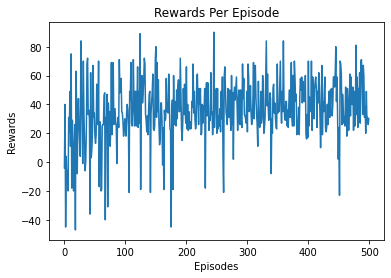

In [ ]:
plt.plot(rew_per_episode)
plt.title('Rewards Per Episode')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

Text(0, 0.5, 'Rewards')

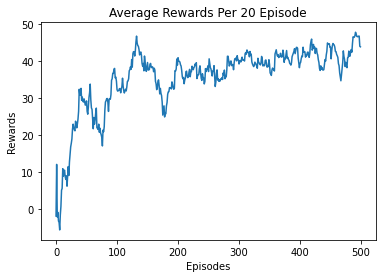

In [ ]:
plt.plot(avg_rewards_per_episodes)
plt.title('Average Rewards Per 20 Episode')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

In [ ]:
for i in range(10):
  cum_rew=0
  done=False
  env.reset()
  while done==False:
    actions=actor(state)
    action=actions.sample()
    next_state,timestep, reward, done, _ = env.step(np.asarray(action))
    cum_rew+=reward
    # print(reward)
  print("Reward for episode ",i,":",cum_rew)

Reward for episode  0 : 22
Reward for episode  1 : 22
Reward for episode  2 : 35
Reward for episode  3 : 18
Reward for episode  4 : 33
Reward for episode  5 : 60
Reward for episode  6 : 35
Reward for episode  7 : 22
Reward for episode  8 : 57
Reward for episode  9 : 21
